# Descriptive

This notebook visualize the images and some values from the data set. 


#### To be done: descriptive table of the NHTS data set. 
#### To be done: visualize the US map and check intuition. Find specific cases and show their values. Make sure that the descriptive level narratives also make sense. 
#### To be done: find a quick way to print the census tracts and their corresponding state-city-county. It helps our intuition.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import util
import statsmodels.api as sm
from scipy import stats
import copy

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# ALWAYS choose devise first.
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization

In [4]:
# 


size = 12000
image_array_ = np.load("/home/jtl/Documents/shenhao/sat_image_nhts/code/data_process/image_array_rgb_tract_large.npy", mmap_mode='r')
rgb_image_array = image_array_[:size,]
image_array_ = np.load("/home/jtl/Documents/shenhao/sat_image_nhts/code/data_process/image_array_bw_tract_large.npy", mmap_mode='r')
bw_image_array = image_array_[:size,]

# 
output_var = "HHVEHCNT_mean"
df_ = pd.read_csv("/home/jtl/Documents/shenhao/sat_image_nhts/code/data_process/df_merged_tract_large.csv")
df = df_.iloc[:size,]
y = df[output_var].values 

output_list = ['HHVEHCNT_mean_norm', 'HHVEHCNT_P_CAP_mean_norm', 'TRPTRANS_1_mean_norm', 'TRPTRANS_2_mean_norm', 'TRPTRANS_3_mean_norm']
input_var=['R_AGE_IMP_mean', 'HHSIZE_mean', 'HHFAMINC_mean', 'HBHTNRNT_mean', 'HBPPOPDN_mean', 'HBRESDN_mean', 
           'R_SEX_IMP_2_mean', 'EDUC_2_mean', 'HH_RACE_2_mean', 'HOMEOWN_1_mean', 'HOMEOWN_2_mean',
           'HBHUR_R_mean', 'HBHUR_S_mean', 'HBHUR_T_mean','HBHUR_U_mean']
BE_var = ['density', 'diversity', 'design']

x = df[input_var].values
BE = df[BE_var].values

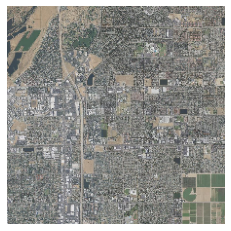

In [25]:
util.imshow(np.moveaxis(rgb_image_array[1001,:,:,:],0,2).astype('uint8'))

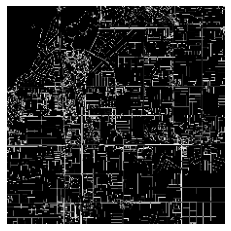

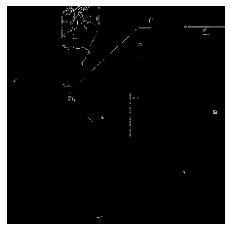

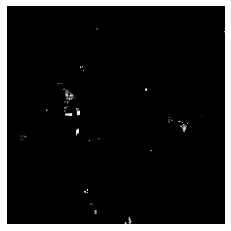

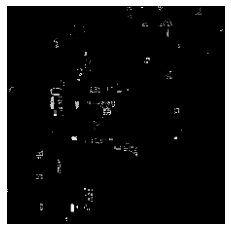

In [5]:
util.imshow(bw_image_array[1001,0,:,:].astype('uint8'))
util.imshow(bw_image_array[1001,1,:,:].astype('uint8'))
util.imshow(bw_image_array[1001,2,:,:].astype('uint8'))
util.imshow(bw_image_array[1001,3,:,:].astype('uint8'))

In [5]:
### randomization
shuffle_idx = np.arange(size)
np.random.seed(0) # seed = 0
np.random.shuffle(shuffle_idx)
train_ratio = 0.8

y_train = y[shuffle_idx[:int(train_ratio*size)]].astype("float32")
y_test = y[shuffle_idx[int(train_ratio*size):]].astype("float32")

x_train_images = rgb_image_array[shuffle_idx[:int(train_ratio*size)],].astype("float32")
x_test_images = rgb_image_array[shuffle_idx[int(train_ratio*size):],].astype("float32")


In [6]:
# transform.
x_train_images_norm = x_train_images/255
x_test_images_norm = x_test_images/255

# to torch
x_train_torch = torch.from_numpy(x_train_images_norm)
x_test_torch = torch.from_numpy(x_test_images_norm)
y_train_torch = torch.from_numpy(y_train)
y_test_torch = torch.from_numpy(y_test)

print(x_train_torch.size())
print(x_test_torch.size())
print(y_train_torch.size())
print(y_test_torch.size())

torch.Size([9600, 3, 224, 224])
torch.Size([2400, 3, 224, 224])
torch.Size([9600])
torch.Size([2400])


In [7]:
# use data loader: train and test. 
train_ds = TensorDataset(x_train_torch, y_train_torch)
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

test_ds = TensorDataset(x_test_torch, y_test_torch)
batch_size = 100
test_dl = DataLoader(test_ds, batch_size, shuffle = True)

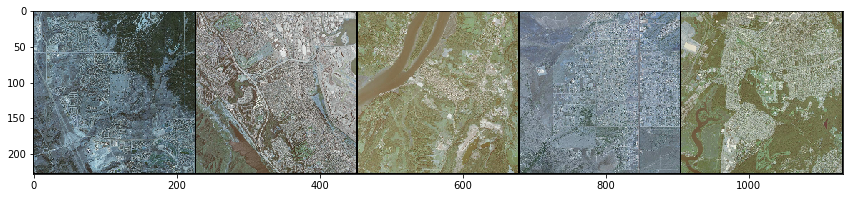

[3.        2.        4.        2.6198347 2.1842105]


In [8]:
# visualize with torchvision.
images_, labels_ = iter(train_dl).next()
images = images_[:5,] # visualize five images
labels = labels_[:5] # visualize five images

def imshow(img):
#     img = img * 255.0     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (15,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(images))
print(labels.numpy())

## Correlation

In [9]:
np.corrcoef(BE.T) # cor matrix.

array([[ 1.        , -0.01596734,  0.66150204],
       [-0.01596734,  1.        ,  0.30296995],
       [ 0.66150204,  0.30296995,  1.        ]])